# Volatility estimators and Quadratic Programming

We use functions defined in our first Notebook on quadratic programmin as well as the volatility estimators defined in the previous Notebook

In [8]:
import numpy as np
import scipy.optimize as sco
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

path = 'C:\\Users\\Arthur\\Documents\\Studies\\ParisDauphineUniversity\\Master203\\M2\\elecmkts\\ElectronicMarkets\\data\\'

def comparison_ef(risks, X, nb_T, s0, v,sigma,benchmark='IS', tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    
    """
    Polots the optimal trading trajectories for a list of risk aversion coefficients
    """
    
    N_opts = []

    for r in risks:
        temp = efficient_frontier(X, r, nb_T, s0, v,sigma,benchmark, tau, gamma, eta, eps,False)

        N_opts.append(temp[0])


    # Plotting
    plt.figure(figsize=(9,6))
    plt.plot(N_opts[0], color='blue', lw=2.0, label='$\lambda$ = '+str(risks[0]))
    plt.plot(N_opts[1], color='green', lw=2.0, label='$\lambda$ = '+str(risks[1]))
    plt.plot(N_opts[2], color='gold', lw=2.0, label='$\lambda$ = '+str(risks[2]))
    plt.plot(N_opts[3], color='darkorange', lw=2.0, label='$\lambda$ = '+str(risks[3]))
    plt.plot(N_opts[4], color='crimson', lw=2.0, label='$\lambda$ = '+str(risks[4]))

    plt.grid(True)
    plt.title('Optimal trajectories for '+benchmark)
    plt.xlabel('Trading periods')
    plt.ylabel('Number of shares')
    plt.legend(loc='best')
    plt.savefig('liquidation_IS.png')
    plt.show()
    
    
def frontier_efficient(risks,X, nb_T, s0, v,sigma,benchmark='IS', tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    
    """
    Plots the efficient frontier for a given benchmark
    """
    
    risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

    x = []
    y = []

    for r in risks:
        temp = efficient_frontier(X, r, nb_T, s0, v,sigma,benchmark, tau, gamma, eta, eps,False)
        x.append(temp[2])  # V(x)
        y.append(temp[1])  # E(x)

    # Plotting
    plt.figure(figsize=(12,6))

    # Optimal strategies
    plt.scatter(x, y, marker='o', cmap='jet', c=risks)
    #plt.plot(x_naive, y_naive, "ro", lw=2, markersize=10, label='Minimum impact', markeredgecolor='red')
    plt.grid(True)

    plt.xlabel('Variance V(x)')
    plt.ylabel('Expectation E(x)')
    plt.title('Efficient frontier for '+benchmark)
    plt.colorbar(label='Risk aversion $\lambda$')
    plt.legend(loc='best')
    plt.savefig('efficient_frontier_IS.png')
    plt.show()
    
def efficient_frontier(X, risk, nb_T, s0, v,sigma,benchmark='IS', tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='True'):
    """
    Returns the optimal expectation and variance as well as the trading trajectory.
    It plots the trading trajectory.
    
    --------------------------------------------------------------------------
    Parameters:

    X, integer - Number of shares to be liquidated
    risk, float - Risk aversion coefficient
    nb_T, integer - Number of trading periods
    gamma, float - Parameter of the permanent market impact
    tau, float - Trading frequency
    eta, float - Parameter of the temporary market impact
    eps, float - Fixed cost of selling in the temporary market impact
        
    
    """
    V = np.sum(v)
    
    ########################################################################################################
    ############################################ MARKET IMPACT #############################################
    ########################################################################################################
    
    def g(x, gamma=2.5*10**(-7), alpha=1.0):
        """
        Permanent market impact
        """
        return gamma * x ** alpha

    def h(x, eta=2.5*10**(-6), epsilon=0.0625, beta=1.0):
        """
        Temporary market impact
        """
        return epsilon*np.sign(x) + eta*(x/tau)**beta

    ########################################################################################################
    ################################################## IS ##################################################
    ########################################################################################################
    
    def expectation_IS(n):
        """
        Returns the expectation of implementation shortfall.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        
        """
        
        exp = 0.5*gamma*X**2 + eps*np.sum(n) + (eta - 0.5*gamma)/tau * np.sum(n**2)
        return exp

    def variance_IS(n):
        """
        Returns the variance of implementation shortfall.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        sigma, array - Volatility of the stock
        
        """
        
        var = 0
        t = - 1
        while t < len(n) - 1:
            t = t + 1
            temp = (X - np.sum(n[0:t])) ** 2
            var = var + temp * sigma[t] **2
        var = tau * var
        return var
    
    def objective_IS(n):
        """
        Returns the objective function for implementation shortfall.
        """
        
        obj = expectation_IS(n) + risk * variance_IS(n)
        return obj
    
    ########################################################################################################
    ################################################## VWAP ################################################
    ########################################################################################################
    
    def expectation_VWAP(n):
        """
        Returns the expected VWAP.

        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        s0, float - Initial spot price
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        v, array - Volume traded during the day
        """
        # s0=100, tau=1, gamma=1, eta=1, eps=1

        N = len(n)
        e = 0
        V = v.sum()
        # T = tau * N
        for k in range(N):
            gsum = 0
            for j in range(k):
                gsum+=g(n[j]/tau)
            e+=(X*v[k]/V - n[k])*(s0-gsum*tau) - X/V * tau*v[k]*g(n[k]/tau) + n[k]*h(n[k]/tau)
        return e

    def variance_VWAP(n):
        """
        Returns the VWAP variance
        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        s0, float - Initial spot price
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        v, array - Volume traded during the day
        """
        # s0=100, X=1000, sigma=0.3, tau=1, gamma=1, eta=1, eps=1
        
        var = 0
        m = len(n)
        V = v.sum()
        for k in range(m):
            vsum = 0
            for j in range(k,m):
                vsum+=v[j]
            x = X - np.sum(n[0:k]) 
            var+=(X/V * vsum - x)**2 *sigma[k]**2
            # print(vsum*X/V, x)
        var = var*tau
        return var

    def objective_VWAP(n):
        """
        Objective function for VWAP.
        """
        obj = expectation_VWAP(n) + risk * variance_VWAP(n)
        return obj
    
    ########################################################################################################
    ################################################## TWAP ################################################
    ########################################################################################################
    
    def expectation_TWAP(n):
        """
        Returns the expected TWAP
        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        s0, float - Initial spot price
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        """
        N = len(n)
        T = tau*N
        e = 0
        for k in range(N):
            sumg=0
            for j in range(k):
                sumg+=g(n[j]/tau)
            e+=(X*tau/T - n[k])*(s0-sumg*tau) - X/T * tau**2*g(n[k]/tau) + n[k]*h(n[k]/tau)
        return e

    def variance_TWAP(n):
        """
        Returns the TWAP variance
        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        s0, float - Initial spot price
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        """
        var=0
        N = len(n)
        T = N * tau
        for k in range(N):
            tsum = 0
            for j in range(k,N):
                tsum+=tau
            x = X - np.sum(n[0:k])
            var+=(X/T * tsum-x)**2*sigma[k]**2*tau
        return var

    def objective_TWAP(n):
        return expectation_TWAP(n) + risk * variance_TWAP(n)
    
    ########################################################################################################
    ############################################ OPTIMIZATION ##############################################
    ########################################################################################################
    
    def optimization(benchmark):
        """
        Optimal execution with optimization for implementation shortfall.
        
        Returns the optimal trading trajectory.
        """
        
        x0  = np.ones((nb_T,1)) * X / nb_T
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        
        if benchmark == "IS":
            opt = sco.minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons) 
            
        elif benchmark == "VWAP":
            opt = sco.minimize(objective_VWAP, x0, method='SLSQP', bounds=bnds, constraints=cons) 
            
        elif benchmark == "TWAP":
            opt = sco.minimize(objective_TWAP, x0, method='SLSQP', bounds=bnds, constraints=cons) 
            
        else:
            raise ValueError("Unknown benchmark: " + str(benchmark))
            
        n = np.array(opt.x)
        return n
    
    def liquidation_history(N_opt, X):
        """
        Prints out the liquidation history of the optimal execution.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        
        """
        
        x_k=[X]
        for i in range(len(N_opt)):
            x_k.append(x_k[i] - N_opt[i])
        return x_k

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.title("Liquidation path for "+benchmark+" and risk faaversion of: " +str(risk))
        plt.show()
    
    N_opt = optimization(benchmark)
    hist_opt = liquidation_history(N_opt,X)
    
    if plot=='True':
        plot_liquidation()
    
    if benchmark == 'IS':
        ex=expectation_IS(N_opt)
        va=variance_IS(N_opt)
    elif benchmark == 'VWAP':
        ex=expectation_VWAP(N_opt)
        va=variance_VWAP(N_opt)
    elif benchmark == 'TWAP':
        ex=expectation_TWAP(N_opt)
        va=variance_TWAP(N_opt)
    else:
        raise ValueError("Unknown benchmark.")
        
    res = hist_opt, ex,va
    
    return res

In [9]:
def volNaive(Price):
    Returns=np.log(Price[1:]/Price[1:].shift(-1))
    return np.std(Returns)

def ZMA_estimator(Price,K):
    """
    Zhang, Mykland & Aït-Sahalia (adjusted) volatility estimator
    """
    # Initialization
    n = Price.shape[0]
    c = 0.25   # This needs to be changed: formula is very complex
    ##K = c * n ** (2/3)
    ##K = int(K)
    n_bar = n / K
    
    # Partition
    def split_seq(seq, size):
        newseq = []
        splitsize = 1.0/size*len(seq)
        for i in range(size):
                newseq.append(seq[int(round(i*splitsize)):int(round((i+1)*splitsize))])
        return newseq
    
    ret_ks = split_seq(Price, K)
    # print(K)
    # Compute vol_k for the entire partition and vol_average
    vol_ks = []
    for ret_k in ret_ks:
        vol_k = volNaive(ret_k)
        vol_ks.append(vol_k)
    
    vol_average = np.mean(vol_ks)
    
    # Compute ZMA estimator
    vol = vol_average - n_bar/n * volNaive(Price)
    vol_adj = (1 - n_bar/n)**(-1) * vol
    
    return vol_adj

def parkinson(High,Low):
    return np.sqrt(1/(4*np.log(2))*np.sum(np.log(High[1:]/Low[1:])**2)*1/(len(High)-1))

def garman_klass(High,Low,Open,Close):
    """
    Garman-Klass volatility estimator. Requires dataframe with Open, High, Low and Close prices.
    """
    log_hl = np.log(High[1:] / Low[1:])
    log_cc = np.log(Close[1:] /Open[1:])
    ans = 0.5*log_hl**2 - (2*np.log(2)-1) * log_cc**2
    return np.sqrt(np.sum(ans)*1/(len(High)-1))

def rogers_satchell(High,Low,Open,Close):
    val=np.log(High[1:]/Close[1:])*np.log(High[1:]/Open[1:])+np.log(Low[1:]/Close[1:])*np.log(Low[1:]/Open[1:])
    return np.sqrt(np.sum(val)*1/len(High))

def garman_klass_yang_zang(High,Low,Open,Close):
    val=np.log(Open[1:]/Close[1:].shift(-1))**2+0.5*(np.log(High[1:]/Low[1:]))**2+(2*np.log(2)-1)*(np.log(Close[1:]/Open[1:]))**2
    return np.sqrt(np.sum(val)*1/(len(High)-1))

Let us import data

In [7]:
path='C:/Users/MBizri/Downloads/data.xlsx'
path = 'C:\\Users\\Arthur\\Documents\\Studies\\ParisDauphineUniversity\\Master203\\M2\\elecmkts\\ElectronicMarkets\\data\\'+'data.xlsx'
data = pd.read_excel(path, sheet_name='1_min_IBM')
data1 = pd.read_excel(path, sheetname='10_min_FP', header=0, index_col=0)
data2 = pd.read_excel(path, sheetname='5_min_FP', header=0, index_col=0)
data3 = pd.read_excel(path, sheetname='1_min_FP', header=0, index_col=0)

C:\Users\Arthur\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [20]:
print(data3.head())
print(data3['Volume'].values)

                       Open   Close    High     Low  Volume         Value
Dates                                                                    
2018-03-01 09:00:00  46.630  46.650  46.665  46.575  185514  8.650095e+06
2018-03-01 09:01:00  46.655  46.725  46.750  46.645   13749  6.420962e+05
2018-03-01 09:02:00  46.710  46.705  46.720  46.655    8316  3.882168e+05
2018-03-01 09:03:00  46.715  46.725  46.730  46.685    8709  4.067956e+05
2018-03-01 09:04:00  46.740  46.755  46.755  46.710    2963  1.384752e+05
[185514  13749   8316 ...  11142   9443  19467]


## 1 minute Data

In [34]:
max_length=data3.shape[0]
SubPeriod=500
Border_up=500
Border_down=0
Garman_KlassS=[]
ParkinsonS=[]
Rogers_SatchellS=[]
Garman_Klass_Yang_ZangS=[]
VolNaives=[]
ZMAs=[]
Number_Periods=int(max_length/SubPeriod)
Time_Period=[]
for j in range(0,Number_Periods):
    High=data3["High"][j*100:SubPeriod+j*100]
    ##High=np.log(High[1:]/High[1:].shift(-1))
    Low=data3["Low"][j*100:SubPeriod+j*100]
    ##Low=np.log(Low[1:]/Low[1:].shift(-1))
    Open=data3["Open"][j*100:SubPeriod+j*100]
    ##Open=np.log(Open[1:]/Open[1:].shift(-1))
    Close=data3["Close"][j*100:SubPeriod+j*100]
    ##Close=np.log(Close[1:]/Close[1:].shift(-1))
    Mid=(High+Low)/2
    Garman_KlassS.append(garman_klass(High,Low,Open,Close))
    ParkinsonS.append(parkinson(High,Low))
    Rogers_SatchellS.append(rogers_satchell(High,Low,Open,Close))
    Garman_Klass_Yang_ZangS.append(garman_klass_yang_zang(High,Low,Open,Close))
    VolNaives.append(volNaive(Mid))
    ZMAs.append(ZMA_estimator(Mid,10))
    Time_Period.append(j*100+500)

Testing volatility method: ZMAs


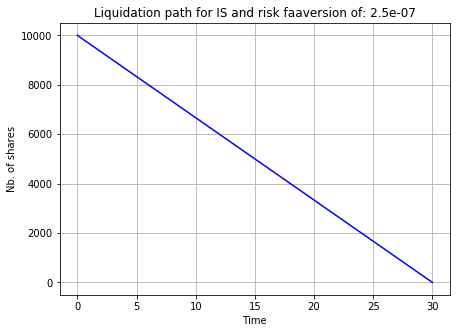

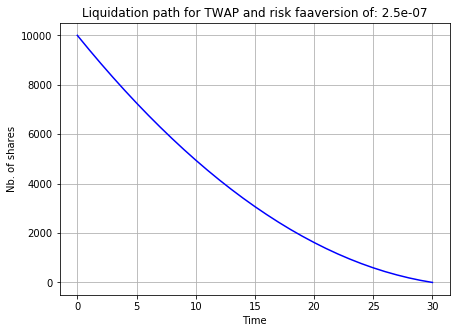

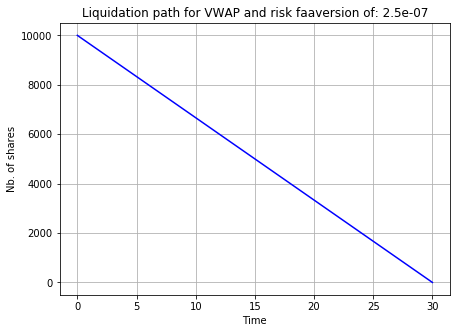

In [45]:
# parameters
nb_T = Number_Periods
risk = 2.5*10**(-7)
s0 = data3.iloc[0,0]
benchmarks = ['IS','TWAP','VWAP']
#V = 4000000
v = data3['Volume'].values# np.ones((nb_T,1)) * V / nb_T
X = 10000

vol_esti = [Garman_KlassS, ParkinsonS, Rogers_SatchellS, Garman_Klass_Yang_ZangS, VolNaives,ZMAs]
vol_esti_names = ["Garman_KlassS", "ParkinsonS", "Rogers_SatchellS", "Garman_Klass_Yang_ZangS", "VolNaives","ZMAs"]

for i in range(5,6): #(len(vol_esti)):
    _sigma = vol_esti[i]
    print("Testing volatility method: "+ vol_esti_names[i])
    for b in benchmarks:
        efficient_frontier(X, risk, nb_T, s0, v,sigma=_sigma,benchmark=b, tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='True')

## 5 minutes Data

In [28]:
max_length=data2.shape[0]
SubPeriod=150
Border_up=500
Border_down=0
Garman_KlassS=[]
ParkinsonS=[]
Rogers_SatchellS=[]
Garman_Klass_Yang_ZangS=[]
VolNaives=[]
ZMAs=[]
Number_Periods=int(max_length/SubPeriod)
Time_Period=[]
for j in range(0,Number_Periods):
    High=data2["High"][j*100:SubPeriod+j*100]
    ##High=np.log(High[1:]/High[1:].shift(-1))
    Low=data2["Low"][j*100:SubPeriod+j*100]
    ##Low=np.log(Low[1:]/Low[1:].shift(-1))
    Open=data2["Open"][j*100:SubPeriod+j*100]
    ##Open=np.log(Open[1:]/Open[1:].shift(-1))
    Close=data2["Close"][j*100:SubPeriod+j*100]
    ##Close=np.log(Close[1:]/Close[1:].shift(-1))
    Mid=(High+Low)/2
    Garman_KlassS.append(garman_klass(High,Low,Open,Close))
    ParkinsonS.append(parkinson(High,Low))
    Rogers_SatchellS.append(rogers_satchell(High,Low,Open,Close))
    Garman_Klass_Yang_ZangS.append(garman_klass_yang_zang(High,Low,Open,Close))
    VolNaives.append(volNaive(Mid))
    ZMAs.append(ZMA_estimator(Mid,15))
    Time_Period.append(j*100+500)

Testing volatility method: Garman_KlassS


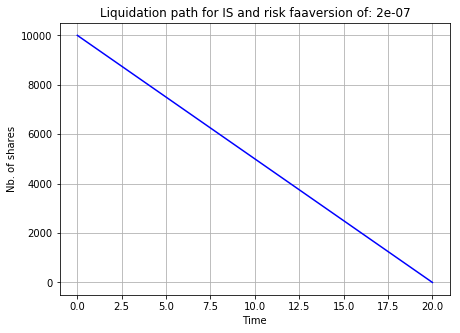

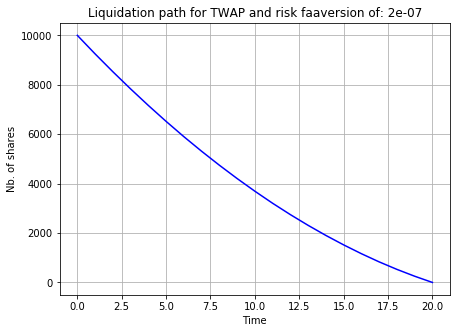

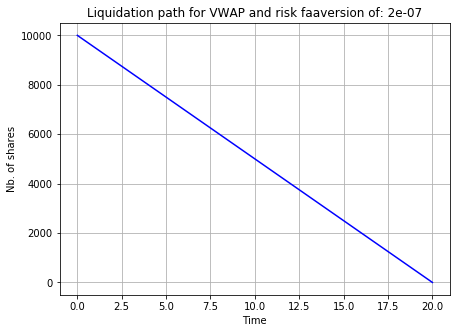

Testing volatility method: ParkinsonS


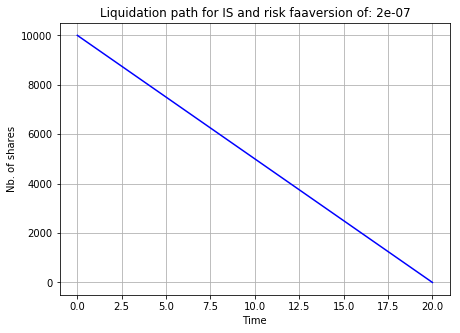

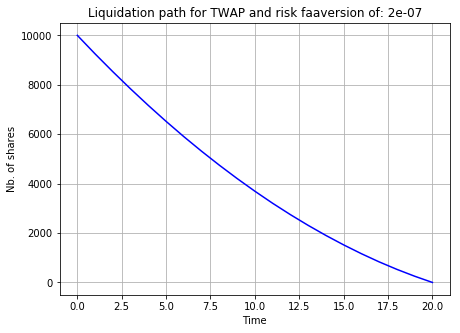

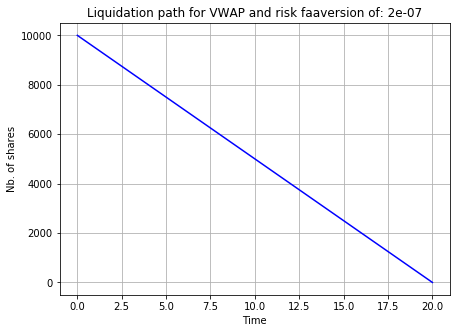

Testing volatility method: Rogers_SatchellS


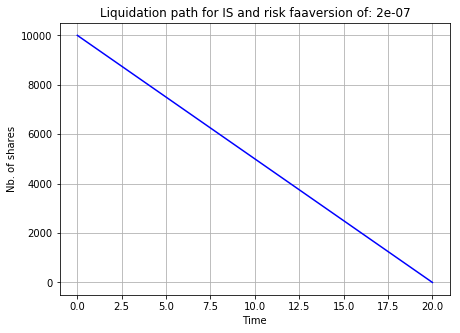

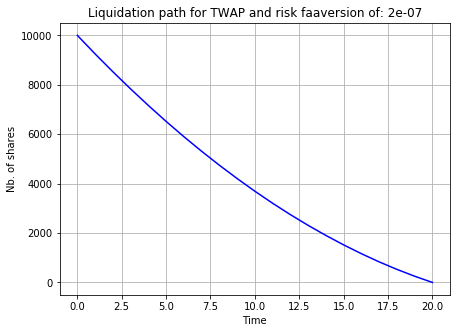

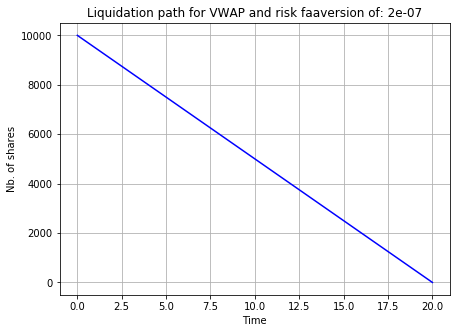

Testing volatility method: Garman_Klass_Yang_ZangS


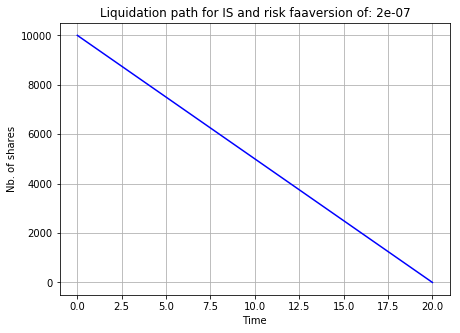

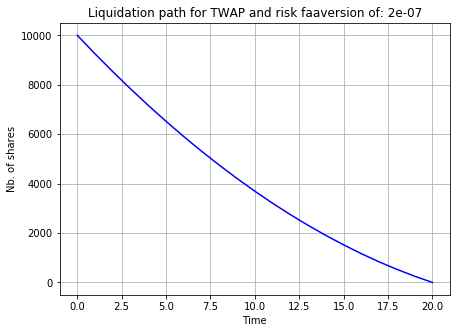

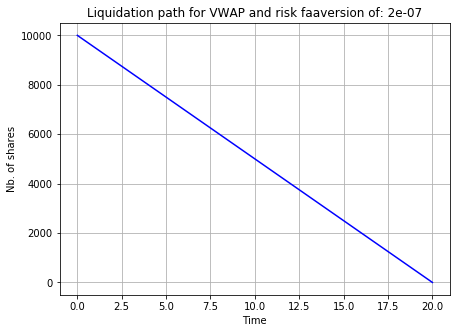

Testing volatility method: VolNaives


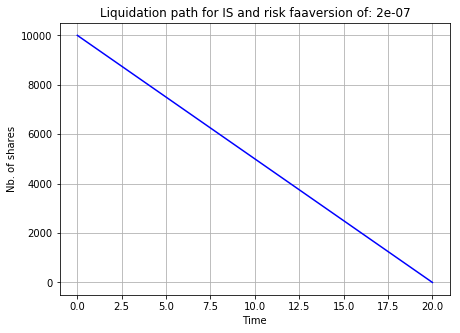

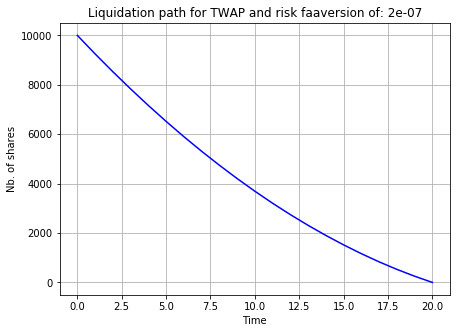

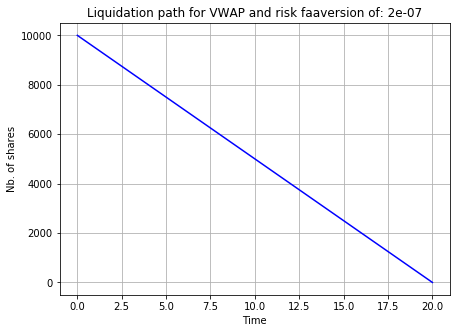

Testing volatility method: ZMAs


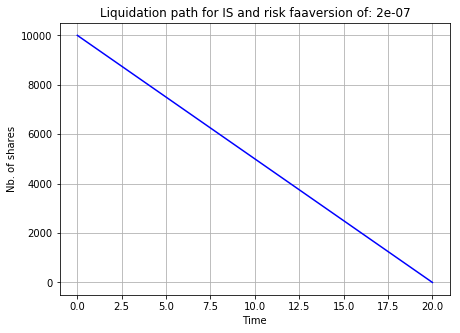

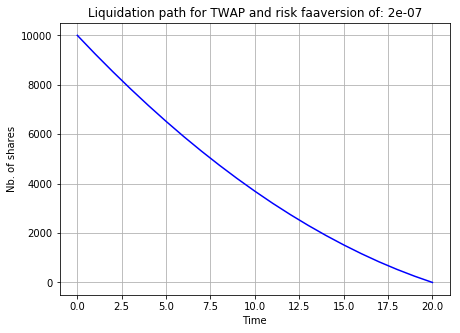

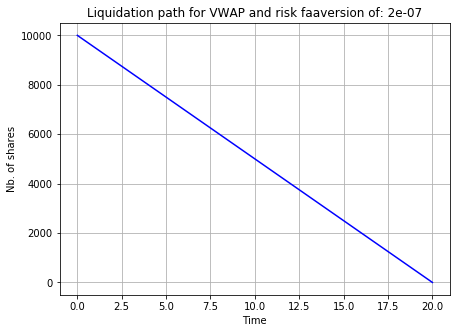

In [29]:
# parameters
nb_T = Number_Periods
risk = 2.5*10**(-7)
s0 = data3.iloc[0,0]
benchmarks = ['IS','TWAP','VWAP']
#V = 4000000
v = data3['Volume'].values# np.ones((nb_T,1)) * V / nb_T
X = 10000

vol_esti = [Garman_KlassS, ParkinsonS, Rogers_SatchellS, Garman_Klass_Yang_ZangS, VolNaives,ZMAs]
vol_esti_names = ["Garman_KlassS", "ParkinsonS", "Rogers_SatchellS", "Garman_Klass_Yang_ZangS", "VolNaives","ZMAs"]

for i in range(len(vol_esti)):
    _sigma = vol_esti[i]
    print("Testing volatility method: "+ vol_esti_names[i])
    for b in benchmarks:
        efficient_frontier(X, risk, nb_T, s0, v,sigma=_sigma,benchmark=b, tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='True')

## 10 minutes Data

In [30]:
max_length=data1.shape[0]
SubPeriod=50
Border_up=500
Border_down=0
Garman_KlassS=[]
ParkinsonS=[]
Rogers_SatchellS=[]
Garman_Klass_Yang_ZangS=[]
VolNaives=[]
ZMAs=[]
Number_Periods=int(max_length/SubPeriod)
print(Number_Periods)
Time_Period=[]
for j in range(0,Number_Periods):
    High=data1["High"][j*10:SubPeriod+j*10]
    ##High=np.log(High[1:]/High[1:].shift(-1))
    Low=data1["Low"][j*10:SubPeriod+j*10]
    ##Low=np.log(Low[1:]/Low[1:].shift(-1))
    Open=data1["Open"][j*10:SubPeriod+j*10]
    ##Open=np.log(Open[1:]/Open[1:].shift(-1))
    Close=data1["Close"][j*10:SubPeriod+j*10]
    ##Close=np.log(Close[1:]/Close[1:].shift(-1))
    Mid=(High+Low)/2
    Garman_KlassS.append(garman_klass(High,Low,Open,Close))
    ParkinsonS.append(parkinson(High,Low))
    Rogers_SatchellS.append(rogers_satchell(High,Low,Open,Close))
    Garman_Klass_Yang_ZangS.append(garman_klass_yang_zang(High,Low,Open,Close))
    VolNaives.append(volNaive(Mid))
    ZMAs.append(ZMA_estimator(Mid,10))
    Time_Period.append(j*10+SubPeriod)

31


Testing volatility method: Garman_KlassS


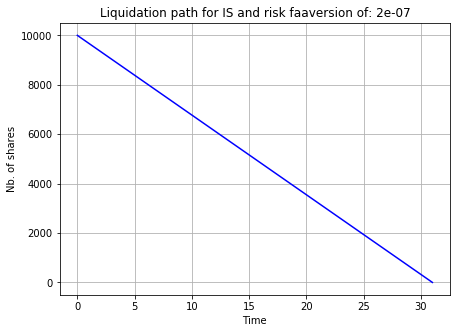

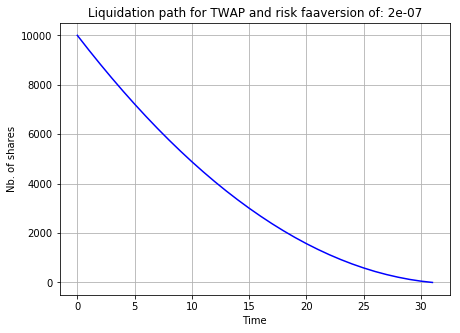

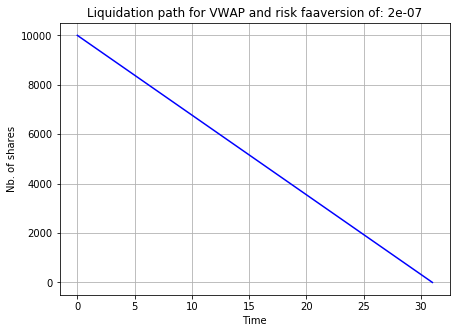

Testing volatility method: ParkinsonS


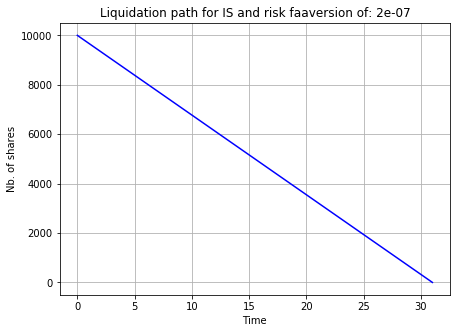

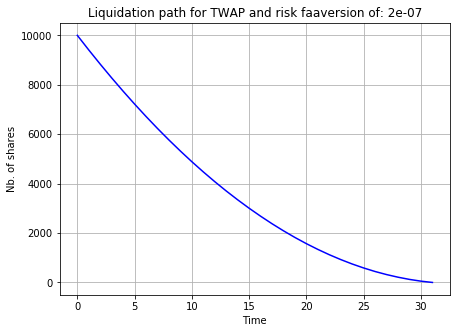

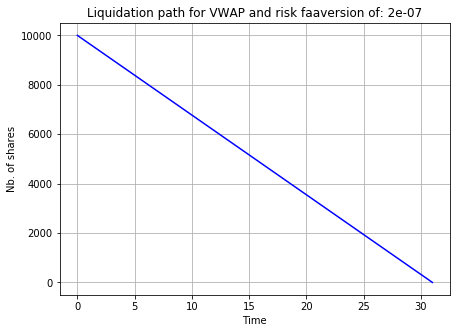

Testing volatility method: Rogers_SatchellS


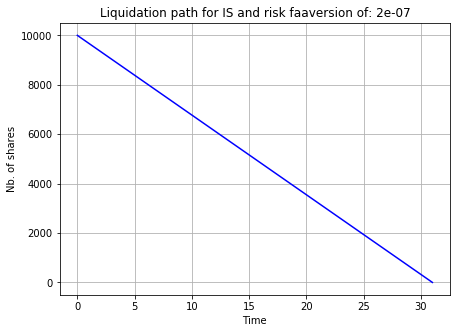

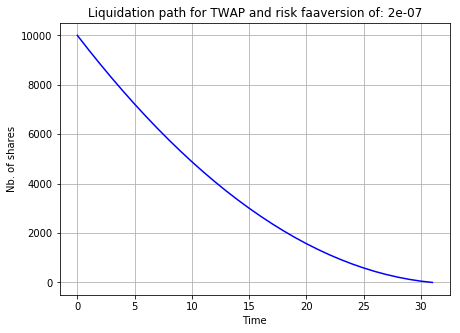

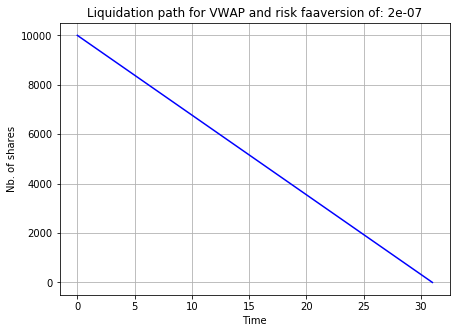

Testing volatility method: Garman_Klass_Yang_ZangS


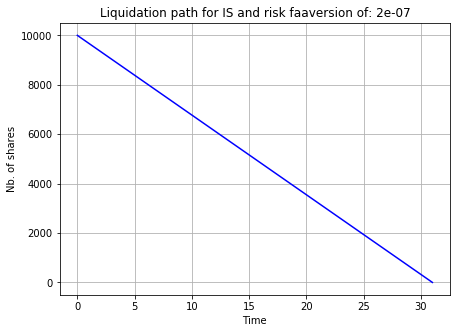

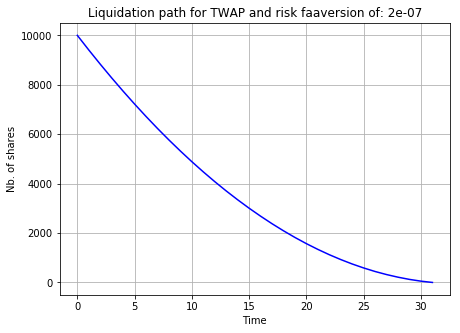

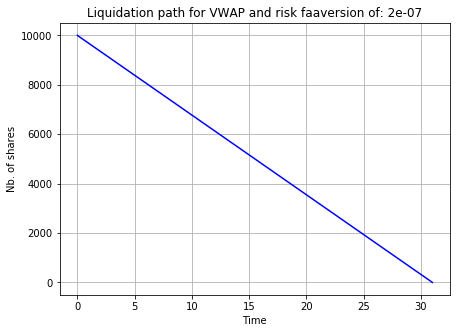

Testing volatility method: VolNaives


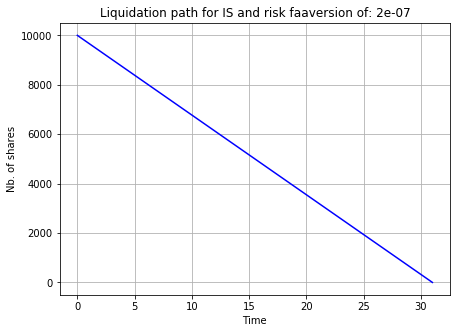

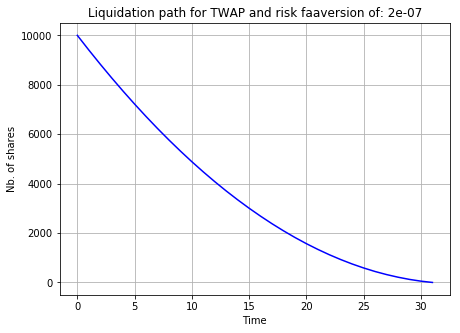

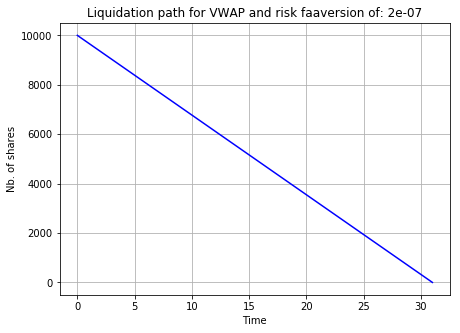

Testing volatility method: ZMAs


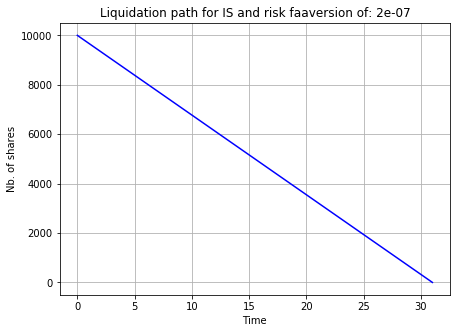

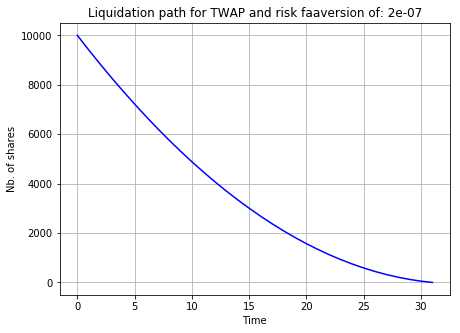

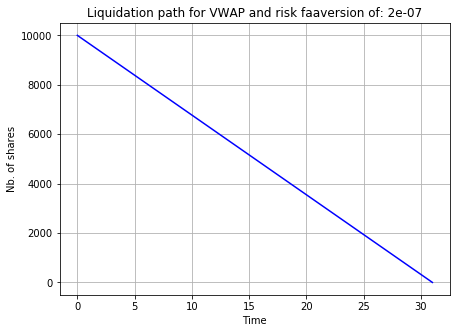

In [31]:
# parameters
nb_T = Number_Periods
risk = 2.5*10**(-7)
s0 = data3.iloc[0,0]
benchmarks = ['IS','TWAP','VWAP']
#V = 4000000
v = data3['Volume'].values# np.ones((nb_T,1)) * V / nb_T
X = 10000

vol_esti = [Garman_KlassS, ParkinsonS, Rogers_SatchellS, Garman_Klass_Yang_ZangS, VolNaives,ZMAs]
vol_esti_names = ["Garman_KlassS", "ParkinsonS", "Rogers_SatchellS", "Garman_Klass_Yang_ZangS", "VolNaives","ZMAs"]

for i in range(len(vol_esti)):
    _sigma = vol_esti[i]
    print("Testing volatility method: "+ vol_esti_names[i])
    for b in benchmarks:
        efficient_frontier(X, risk, nb_T, s0, v,sigma=_sigma,benchmark=b, tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='True')

Whatever the data frequency used (1min, 5mi, 10min) and the volatility estimators used, the trading does not change much. Therefore as surprising as it seems, the sensitivity to the volatility is very low. 

For market practitioners this means that they can use a naive volatility and do not need to take care of this.
This might be less true in a continuous time framework with Bid, Asks and market depth.

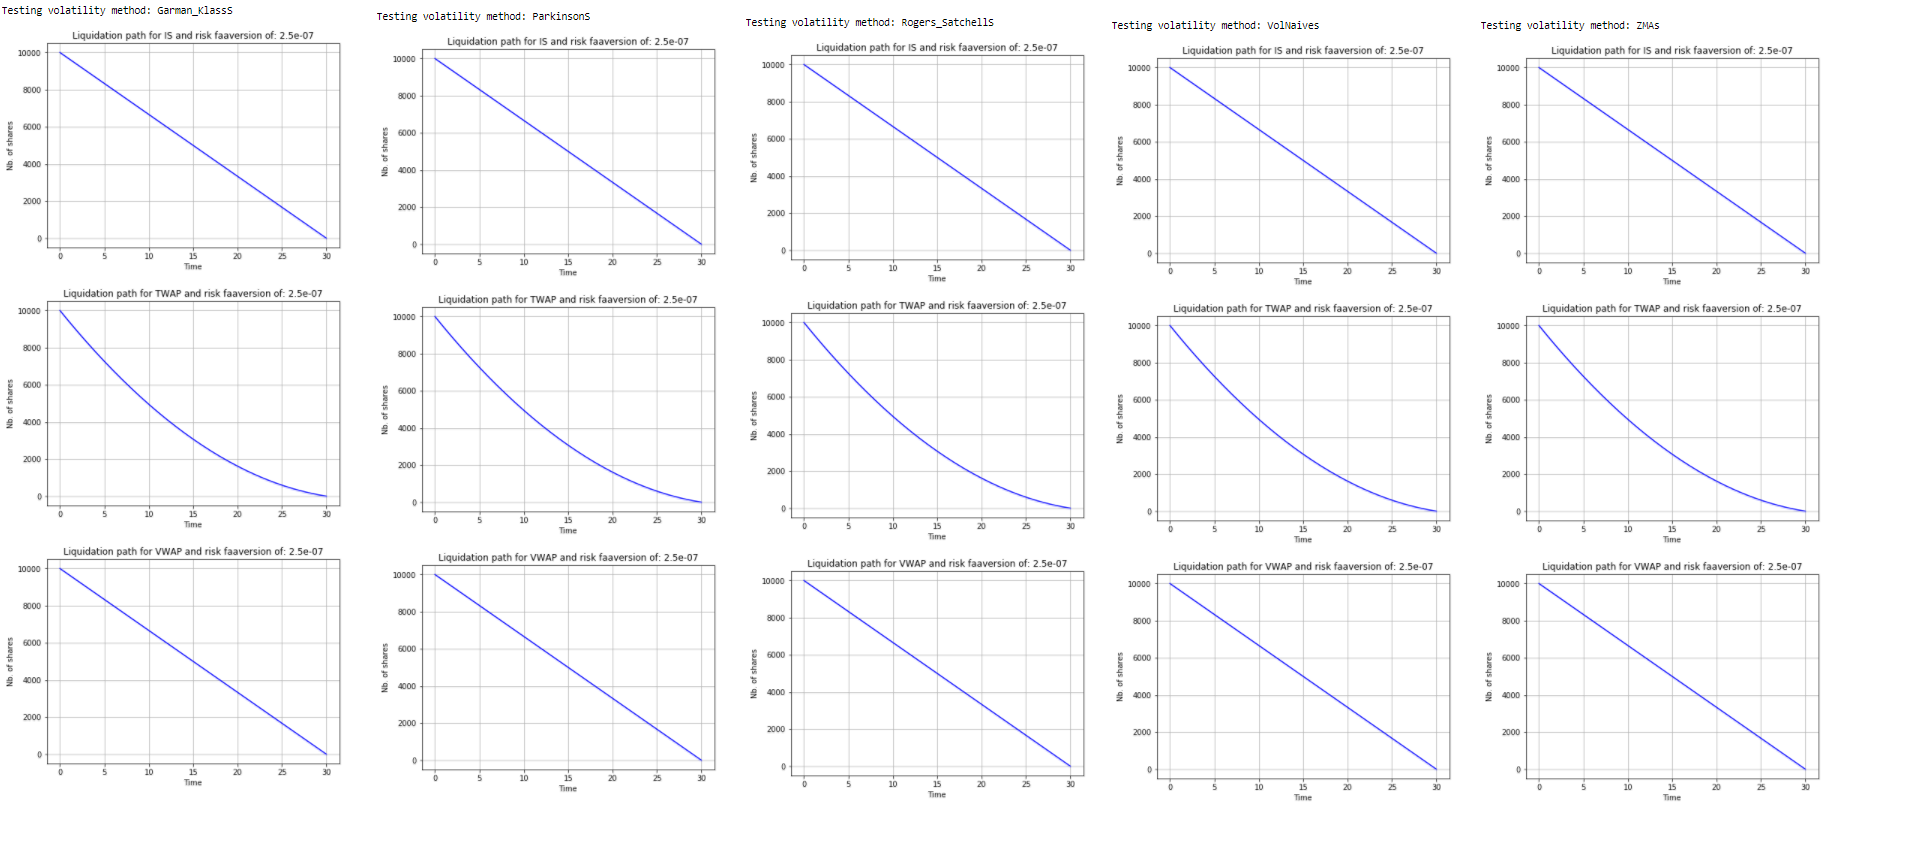

In [7]:
path = 'C:\\Users\\Arthur\\Documents\\Studies\\ParisDauphineUniversity\\Master203\\M2\\elecmkts\\ElectronicMarkets\\LatexGraphs\\'

Image(filename=path+"1min_vol_comparison.png", height=1000, width=1000)